UNI-bs3118

Part 2


---


The dataset is split into training, testing and validation. We use MobileNet network as the third application. The accuracy achieved for validation is 99.64%. The testing data gives a 100% accuracy. The MobileNet network has about 3 million parameters which is the very small compared to the rest of the models. 

Overall, the model with the least number of parameters is the MobileNet model.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

#Code to download the dataset from the Google Drive as a zip file
from google.colab import drive
drive.mount('/content/gdrive')

!unzip "/content/gdrive/My Drive/Colab Notebooks/dataset.zip"

base_dir = '/content/dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_alma_dir = os.path.join(train_dir, 'alma')
train_lion_dir = os.path.join(train_dir, 'lion')
train_thinker_dir = os.path.join(train_dir, 'thinker')


validation_alma_dir = os.path.join(validation_dir, 'alma')
validation_lion_dir = os.path.join(validation_dir, 'lion')
validation_thinker_dir = os.path.join(validation_dir, 'thinker')

test_alma_dir = os.path.join(test_dir, 'alma')
test_lion_dir = os.path.join(test_dir, 'lion')
test_thinker_dir = os.path.join(test_dir, 'thinker')


num_alma_tr = len(os.listdir(train_alma_dir))
num_lion_tr = len(os.listdir(train_lion_dir))
num_thinker_tr = len(os.listdir(train_thinker_dir))

num_alma_test = len(os.listdir(test_alma_dir))
num_lion_test = len(os.listdir(test_lion_dir))
num_thinker_test = len(os.listdir(test_thinker_dir))

num_alma_val = len(os.listdir(validation_alma_dir))
num_lion_val = len(os.listdir(validation_lion_dir))
num_thinker_val = len(os.listdir(validation_thinker_dir))


total_train = num_alma_tr + num_lion_tr + num_thinker_tr 
total_val = num_alma_val + num_lion_val + num_thinker_val 
total_test = num_alma_test + num_lion_test + num_thinker_test 

print('Training alma images:', num_alma_tr)
print('Training lion images:', num_lion_tr)
print('Training thinker images:', num_thinker_tr)

print('Test alma images:', num_alma_test)
print('Test lion images:', num_lion_test)
print('Test thinker images:', num_thinker_test)

print('Validation alma images:', num_alma_val)
print('Validation lion images:', num_lion_val)
print('Validation thinker images:', num_thinker_val)


print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

TARGET_SHAPE = 224
BATCH_SIZE = 32
conv_base = MobileNet(input_shape=(224,224,3),alpha=1.0,depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', classes=5)


datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
#             print("adfvsd")
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1093)
validation_features, validation_labels = extract_features(validation_dir, 274)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/Colab Notebooks/dataset.zip
replace dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Training alma images: 357
Training lion images: 436
Training thinker images: 301
Test alma images: 149
Test lion images: 182
Test thinker images: 126
Validation alma images: 89
Validation lion images: 109
Validation thinker images: 76
Total training images: 1094
Total validation images: 274
Total test images: 457
Found 1093 images belonging to 3 classes.
Found 274 images belonging to 3 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

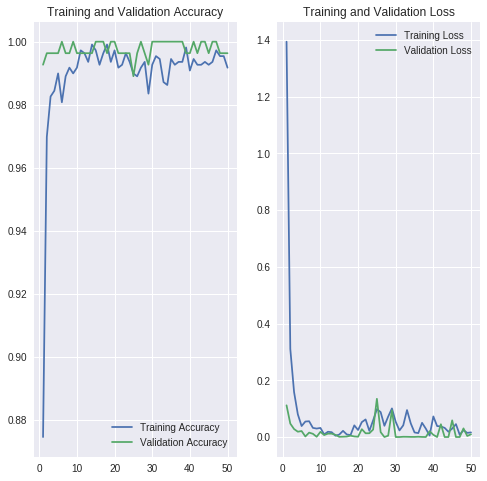

In [4]:
FLATTENED_SHAPE = 7 * 7 * 1024
conv_base = MobileNet(input_shape=(224,224,3),alpha=1.0,depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', classes=5)

conv_base.summary()
train_features = np.reshape(train_features, (total_train-1, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
  
test_features, test_labels = extract_features(test_dir, 457)
test_features = np.reshape(test_features, (457, FLATTENED_SHAPE))

Found 457 images belonging to 3 classes.


In [18]:
model.evaluate(test_features,y=test_labels,verbose=1)

457/457 [==============================] - 0s 376us/sample - loss: 1.9038e-06 - acc: 1.0000


[1.9037719964191728e-06, 1.0]